# Classifying Cats and Dogs and Evaluating with Confusion Matrix
Some of the code here used is based on: https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb

And also on the *Convolutional Neural Networks with Tensorflow* course on Coursera

This notebook is intended to be used in google colab.

### Downloading and unzipping dataset

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import tensorflow as tf
from tensorflow import keras
print("TensorFlow version is ", tf.__version__)

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

TensorFlow version is  1.13.1


In [2]:
zip_file = tf.keras.utils.get_file(origin="https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip",
                                   fname="cats_and_dogs_filtered.zip", extract=True)
base_dir, _ = os.path.splitext(zip_file)
base_dir

'/home/leninml/.keras/datasets/cats_and_dogs_filtered'

### Creating train and validation folders

In [3]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
print ('Total training cat images:', len(os.listdir(train_cats_dir)))

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
print ('Total training dog images:', len(os.listdir(train_dogs_dir)))

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
print ('Total validation cat images:', len(os.listdir(validation_cats_dir)))

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print ('Total validation dog images:', len(os.listdir(validation_dogs_dir)))

Total training cat images: 1000
Total training dog images: 1000
Total validation cat images: 500
Total validation dog images: 500


### Generators

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = 160 # All images will be resized to 160x160
batch_size = 20

# Rescale all images by 1./255 and apply image augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
# Add our data-augmentation parameters to ImageDataGenerator
# train_datagen = ImageDataGenerator(rescale = 1./255.,
#                                    rotation_range = 40,
#                                    width_shift_range = 0.2,
#                                    height_shift_range = 0.2,
#                                    shear_range = 0.2,
#                                    zoom_range = 0.2,
#                                    horizontal_flip = True)


validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                train_dir,  # Source directory for the training images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                # Since we use binary_crossentropy loss, we need binary labels
                class_mode='binary')


# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(
                validation_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Base Model

In [5]:
IMG_SHAPE = (image_size, image_size, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


### Freezing Layers

In [6]:
base_model.trainable = False
# for layer in base_model.layers:
#     layer.trainable = False
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

### Adding CNN for classification

In [7]:
model = tf.keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(1, activation='sigmoid')
])

### Compiling Model

In [8]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer= RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [9]:
len(model.trainable_variables)

2

### Training the Model

In [10]:
epochs = 10
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size
print('steps per epoch: %d, validation steps %d'%(steps_per_epoch, validation_steps))
print('train generator n: %d validation generator n: %d'%(train_generator.n, validation_generator.n))

steps per epoch: 100, validation steps 50
train generator n: 2000 validation generator n: 1000


In [11]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              workers=4,
                              validation_data=validation_generator,
                              validation_steps=validation_steps)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
100/100 [==============================] - 51s 510ms/step - loss: 0.6426 - acc: 0.6360 - val_loss: 0.4957 - val_acc: 0.8010
Epoch 2/10
100/100 [==============================] - 40s 403ms/step - loss: 0.4892 - acc: 0.7855 - val_loss: 0.3604 - val_acc: 0.8780
Epoch 3/10
100/100 [==============================] - 43s 434ms/step - loss: 0.3984 - acc: 0.8460 - val_loss: 0.2846 - val_acc: 0.9120
Epoch 4/10
100/100 [==============================] - 43s 433ms/step - loss: 0.3512 - acc: 0.8705 - val_loss: 0.2478 - val_acc: 0.9200
Epoch 5/10
100/100 [==============================] - 44s 436ms/step - loss: 0.3062 - acc: 0.8965 - val_loss: 0.2178 - val_acc: 0.9250
Epoch 6/10
100/100 [==============================] - 51s 513ms/step - loss: 0.2766 - acc: 0.9045 - val_loss: 0.2032 - val_acc: 0.9220
Epoch 7/10
100/100 [==============================] - 53s 533ms/step - loss: 0.2616 - acc: 0.8990 - val_loss: 0.1913 - val_acc: 0.9250
Epoch 8

### Plotting training

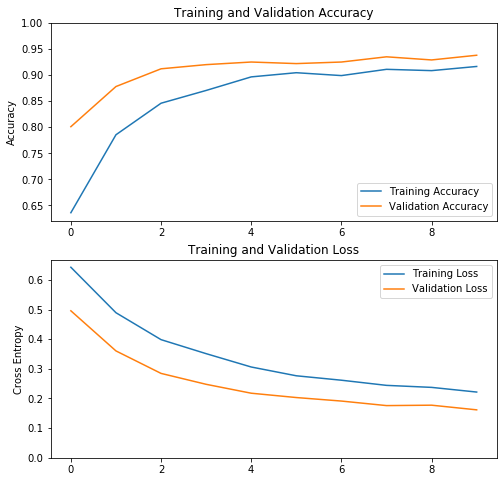

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

### Model evaluation on valid dataset

Reference: https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720


In [13]:
model.evaluate_generator(generator=validation_generator,
steps=validation_steps, verbose=1)

50/50 [==============================] - 16s 323ms/step - loss: 0.1617 - acc: 0.9380


[0.1617353968322277, 0.938]

In [14]:
model.metrics_names

['loss', 'acc']

Model evaluation using confusion matrix
If we wanted to predict using confusion matrix on validation dataset we have to re-generate it with shuffle false. This is the behavior. a bit strange

In [15]:
from sklearn.metrics  import confusion_matrix
validation_generator_cm = validation_datagen.flow_from_directory(
                validation_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='binary',
                shuffle = False)
validation_generator_cm.reset()

y_pred_valid = model.predict_classes(validation_generator_cm, verbose =1)
cm_valid = confusion_matrix(y_true=validation_generator.labels, y_pred=y_pred_valid)
print(cm_valid)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 17s 349ms/step
[[483  17]
 [ 45 455]]


In [16]:
from sklearn.metrics import accuracy_score
acc_training = accuracy_score(y_true=validation_generator.labels, y_pred=y_pred_valid)
acc_training


0.938

In [17]:
# Note that the validation data should not be augmented!
test_base_dir = '.'

test_dir = os.path.join( test_base_dir, 'test')
print(os.listdir(test_dir))
# Note that the validation data should not be augmented!
test_datagen_2 = ImageDataGenerator( rescale = 1.0/255. )

# Flow validation images in batches of 20 using test_datagen generator
test_generator =  test_datagen_2.flow_from_directory( test_dir,
                                                      batch_size  = 1,
                                                      class_mode  = 'binary', 
                                                      target_size = (image_size, image_size),
                                                      shuffle = False)

['dogs', 'cats']
Found 10 images belonging to 2 classes.


In [18]:
test_generator.class_indices

{'cats': 0, 'dogs': 1}

In [19]:
test_generator.filenames

['cats/cat.1.jpg',
 'cats/cat.2.jpg',
 'cats/cat.3.jpg',
 'cats/cat.4.jpg',
 'cats/cat.5.jpg',
 'dogs/dog.1.jpg',
 'dogs/dog.2.jpg',
 'dogs/dog.3.jpg',
 'dogs/dog.4.jpg',
 'dogs/dog.5.jpg']

In [20]:
train_generator.class_indices

{'cats': 0, 'dogs': 1}

In [21]:
filenames = test_generator.filenames
nb_samples = len(filenames)
test_generator.reset()
# validation_generator.reset()
y_predict_prob = model.predict_generator(test_generator,steps = nb_samples, verbose=1)
# y_predict = model.predict_classes(test_generator, verbose=1)
y_predict_class = model.predict_classes(test_generator)
# y_predict = model.predict_generator(validation_generator)
print('class \n', y_predict_class)
print('prob: \n', y_predict_prob)

10/10 [==============================] - 1s 123ms/step
class 
 [[0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]]
prob: 
 [[0.02520979]
 [0.03020125]
 [0.01538037]
 [0.00297878]
 [0.00806312]
 [0.9660138 ]
 [0.95263183]
 [0.84455276]
 [0.9827414 ]
 [0.49396694]]


In [22]:
# y_predict_rounded = np.round(y_predict, decimals=0)
# y_predict_rounded

In [23]:
# predicted_class_indices=np.argmax(y_predict,axis=1)
predicted_class_indices = [1 if k>0.5 else 0 for k in y_predict_prob]
predicted_class_indices

[0, 0, 0, 0, 0, 1, 1, 1, 1, 0]

In [24]:
import pandas as pd
df = pd.DataFrame(columns=['filename', 'class-true-value', 'class-pred-value', 'class-prob'])
df['filename'] = test_generator.filenames
df['class-true-value'] = test_generator.labels
df['class-pred-value'] = y_predict_class
df['class-prob'] = y_predict_prob
# test_generator.class_indices
df

,filename,class-true-value,class-pred-value,class-prob
0,cats/cat.1.jpg,0,0,0.025210
1,cats/cat.2.jpg,0,0,0.030201
2,cats/cat.3.jpg,0,0,0.015380
3,cats/cat.4.jpg,0,0,0.002979
4,cats/cat.5.jpg,0,0,0.008063
5,dogs/dog.1.jpg,1,1,0.966014
6,dogs/dog.2.jpg,1,1,0.952632
7,dogs/dog.3.jpg,1,1,0.844553
8,dogs/dog.4.jpg,1,1,0.982741
9,dogs/dog.5.jpg,1,0,0.493967


### Confusion Matrix

In [25]:
from sklearn.metrics  import confusion_matrix
# y_true = test_generator.labels
# y_pred = y_predict_rounded
cm = confusion_matrix(y_true=test_generator.labels, y_pred=y_predict_class) # 1
# cm = confusion_matrix(validation_generator.labels, y_predict_rounded)  # 2
# cm = confusion_matrix(y_true=test_generator.labels, y_pred=predicted_class_indices) # it makes the same as 1
cm

array([[5, 0],
       [1, 4]])

Plotting Confusion Matrix:

* https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
* https://github.com/anujshah1003/own_data_cnn_implementation_keras/blob/master/updated_custom_data_cnn.py

In [26]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[5 0]
 [1 4]]


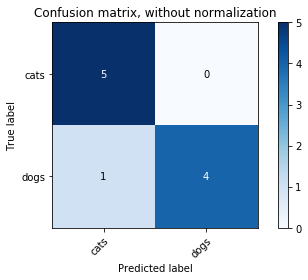

In [27]:
# from sklearn import datasets
# iris = datasets.load_iris()
# class_names = iris.target_names
# class_names
from sklearn.utils.multiclass import unique_labels
# xs = unique_labels(test_generator.labels, predicted_class_indices)
# print(xs)
plot_confusion_matrix(y_true=test_generator.labels, y_pred=y_predict_class, classes=['cats', 'dogs'])
plt.show()


In [28]:
def plot_confusion_matrix2(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[5 0]
 [1 4]]


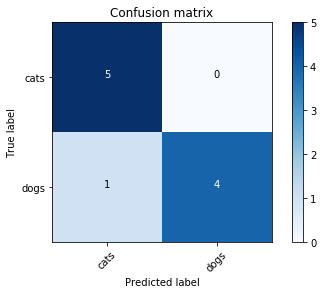

In [29]:
import itertools
plot_confusion_matrix2(cm, classes=['cats', 'dogs'])
plt.show()

### Accuracy

In [30]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true=test_generator.labels, y_pred=y_predict_class)
# accuracy_score(y_true=validation_generator.labels, y_pred=y_predict_rounded)

0.9

### Classification Report

In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_true=test_generator.labels, y_pred=y_predict_class))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.80      0.89         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10



## Prediction

Let us define a function to predict the class of an individual image from folder **/test**

In [34]:
import numpy as np
from keras.preprocessing import image


def prediction(path_img):
    img = image.load_img(path_img, target_size=(image_size,image_size))
    x = image.img_to_array(img)
    x = x/255.
    x = np.expand_dims(x, axis=0)
#     classes = model.predict(x)
    classes = model.predict_classes(x)
    plt.imshow(img)
    if classes > 0.5:
        print(path_img.split('/')[-1]+' is a dog')
    else:
        print(path_img.split('/')[-1]+' is a cat')   
    return classes


Using TensorFlow backend.


cat.1.jpg is a cat
[[0]]


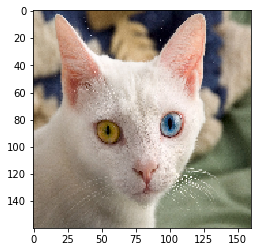

In [35]:
y1 = prediction(path_img='./test/cats/cat.1.jpg')
print(y1)

dog.3.jpg is a dog
[[1]]


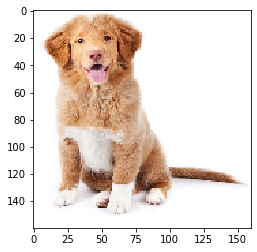

In [36]:
y2 = prediction(path_img='./test/dogs/dog.3.jpg')
print(y2)

In [37]:
# test = os.listdir('./test/')
print(test_dir)
y_pred_m = []
files=[]
for filename in os.listdir(test_dir):
    file = test_dir+'/'+filename
    for item in os.listdir(file):
        file2 = file+'/'+item
        if file2.split('.')[-1]=='jpg':
            files.append(file2)
files

./test


['./test/dogs/dog.5.jpg',
 './test/dogs/dog.2.jpg',
 './test/dogs/dog.3.jpg',
 './test/dogs/dog.4.jpg',
 './test/dogs/dog.1.jpg',
 './test/cats/cat.2.jpg',
 './test/cats/cat.1.jpg',
 './test/cats/cat.4.jpg',
 './test/cats/cat.5.jpg',
 './test/cats/cat.3.jpg']

dog.5.jpg is a cat
dog.2.jpg is a dog
dog.3.jpg is a dog
dog.4.jpg is a dog
dog.1.jpg is a dog
cat.2.jpg is a cat
cat.1.jpg is a cat
cat.4.jpg is a cat
cat.5.jpg is a cat
cat.3.jpg is a cat


array([[[0]],

       [[1]],

       [[1]],

       [[1]],

       [[1]],

       [[0]],

       [[0]],

       [[0]],

       [[0]],

       [[0]]], dtype=int32)

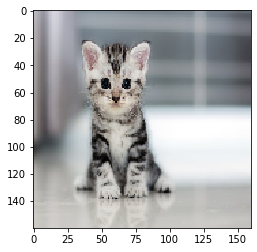

In [38]:
prediction_array = [prediction(img) for img in files]

np.round(prediction_array, decimals=0)

## ROC CURVES
we are going to plot ROC CURVES for the binary problem of classification. We based on:
* https://hackernoon.com/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier-2ecc6c73115a
* https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a

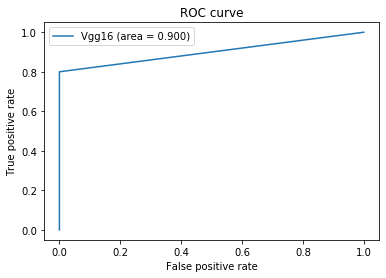

In [39]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_pred_roc = model.predict_classes(test_generator).ravel()
fpr, tpr, thresholds = roc_curve(test_generator.labels, y_pred_roc)
auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label = 'Vgg16 (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [40]:
auc

0.9